In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys 
import os
import pyodbc
import sqlalchemy as sa
from sklearn.preprocessing import LabelEncoder
os.getcwd()
#sys.path.append(os.path.abspath("d:\\Project\Modulos"))
#from Modulos.ConexionSQL import Conexion 
os.chdir('D:\Experiencia Cliente\Bases')
os.listdir()

['BaseFinal_Gestion.xlsx',
 'Base_gestion_CDXL_202303_TGS.xlsx',
 'Base_gestion_CDXL_202303_TGS_Choc.xlsx',
 'Base_gestion_CDXL_202304_TGS.xlsx',
 'Base_gestion_CDXL_202304_TGS_Choc.xlsx',
 'Base_gestion_CDXL_202305_TGS.xlsx',
 'Base_gestion_CDXL_202305_TGS_Choc.xlsx',
 'Base_gestion_CDXL_202306_TGS.xlsx',
 'Base_gestion_CDXL_202306_TGS_Choc.xlsx',
 'Base_gestion_CDXL_202307_TGS.xlsx',
 'Base_gestion_CDXL_202307_TGS_Choc.xlsx',
 'Base_gestion_CDXL_202308_TGS.xlsx',
 'Base_gestion_CDXL_202308_TGS_BoosterPremium.xlsx',
 'Base_gestion_CDXL_202308_TGS_Choc.xlsx',
 'Base_gestion_CDXL_202308_TGS_Nuevos.xlsx',
 'Base_gestion_CDXL_202309_TGS.xlsx',
 'Calendario.xlsx',
 'descriptivos.csv',
 'gestión diaria.xlsx',
 'Muestreo_Grupos2023-08-29.xlsx',
 'PERSONAL CD 2023.xlsx',
 'seguimientodeuda.xls',
 'TipoVariable.csv',
 'variables.csv',
 'Varibles_dataframe.csv',
 'ver2.xlsx',
 'ver_1.xlsx',
 '~$Calendario.xlsx',
 '~$revisar_1.xlsx']

In [2]:
def binnings(y_real, probas, bins=5):

    result = pd.DataFrame()
    result['prob'] = probas[:,1] 
    grupos = ['G'+str(i+1) for i in range(bins)]
    result['predict'] = result['prob'].apply(lambda x : int(x>=0.5))
    result['real'] = y_real.reset_index(drop=True)
    result['binnis'] = pd.qcut(1-result['prob'],q=bins, labels=grupos)
    return pd.crosstab(result['binnis'], result['real'], normalize='columns')

In [3]:
df_gestion = pd.read_excel('BaseFinal_Gestion.xlsx')

In [4]:
temp = df_gestion[df_gestion['Target']==1][['Target','call_date']]
temp['call_date'] = pd.to_datetime(temp['call_date'])
temp['Mes'] = temp['call_date'].dt.month
temp['dia'] = temp['call_date'].dt.day
temp = temp.groupby(['Mes','dia'])['Target'].sum( ).reset_index(name="Count")
temp['rank'] = temp.groupby(['Mes'])['dia'].rank(method="dense", ascending=True)
temp['cumsum'] = temp.groupby(['Mes'])['Count'].cumsum()
# Calcular el porcentaje de cumsum para cada Mes
temp['cumsum_percent'] = temp['cumsum'] / temp.groupby('Mes')['Count'].transform('sum')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


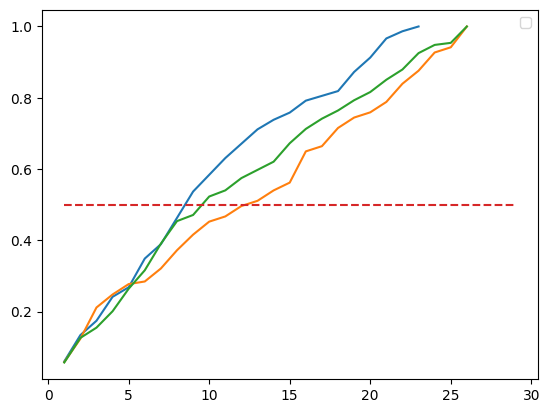

In [5]:
serie1 = temp[temp['Mes'] ==4][['rank','cumsum_percent']]
serie2 = temp[temp['Mes'] ==5][['rank','cumsum_percent']]
serie3 = temp[temp['Mes'] ==6][['rank','cumsum_percent']]


plt.plot(serie1['rank'], serie1['cumsum_percent'])
plt.plot(serie2['rank'], serie2['cumsum_percent'])
plt.plot(serie3['rank'], serie3['cumsum_percent'])
plt.plot(range(1,30),[0.5 for i in range(1,30)], '--')
plt.legend()
plt.show()


In [6]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [7]:
def tratamiento(fecha = '2023-06-30', export_missing= False):
    #información del personal
    df_personal = pd.read_excel('PERSONAL CD 2023.xlsx')
    df_personal.shape
    df_personal.drop(['DNI','COD_VEN','NOMBRE_ASESOR', 'ESTADO', 'FECHA_CESE'], axis=1, inplace =  True)
    df_personal.rename(columns ={'USERVICI' : 'user'}, inplace = True)
    #información de la gestión
    df_gestion = pd.read_excel('BaseFinal_Gestion.xlsx')
    df_gestion.shape
    df_gestion = df_gestion.merge(df_personal, on='user', how ='left')
    #filtrar el mes
    df_gestion =df_gestion[df_gestion['FechaMes'] == fecha]


    df_gestion['FechaMes'] = pd.to_datetime(df_gestion['FechaMes'] )
    df_gestion['FechaCarga'] = pd.to_datetime(df_gestion['FechaCarga'] )
    df_gestion['call_date'] = pd.to_datetime(df_gestion['call_date'] )
    df_gestion['Dni'] = df_gestion['Dni'].apply(lambda x : ('00000000'+str(x).split('.')[0])).str[-8:]
    #LLave para el join
    df_gestion['key'] = df_gestion['Numero_Campaña'].astype(str).str[:6] + '-' + df_gestion['Dni'].astype(str)
    
    new_fecha = fecha.replace('-','')[:6]
    #carga de información de los prospectos
    Base = [x for x in  os.listdir() if x.startswith('Base_gestion_CDXL_'+new_fecha)]
    print(Base)
    df_inicial = pd.DataFrame()

    for base in Base:
        temp = pd.read_excel(base)
        temp['file']=base
        df_inicial = pd.concat([temp,df_inicial])

    df_inicial['DOCUMENTO'] = df_inicial['DOCUMENTO'].apply(lambda x : ('00000000'+str(x).split('.')[0])).str[-8:]
    df_inicial['PERIODO'] = df_inicial['PERIODO'].apply(lambda x : str(x).split('.')[0]).astype(str)

    #Llave para el join
    df_inicial['key'] = df_inicial['PERIODO']+'-'+ df_inicial['DOCUMENTO']

    df = df_inicial.copy()
    df['Rank'] =df.groupby(by=['key'])['RSNCODE'].transform(lambda x: x.rank(ascending=False))
    df = df[df['Rank']==1]
    df.reset_index(drop =True, inplace = True)


    def moneda(x):
        x = str(x).split(' ')[-1].replace(',','')
        return float(x) 
    
    Monto_Deuda =['MONTO_DEUDA1', 'MONTO_DEUDA2', 'MONTO_DEUDA3', 'MONTO_DEUDA4'] 

    for Monto in Monto_Deuda:
        df[Monto] = df[Monto].apply(lambda x: moneda(x))


    df['CICLO_FACTURACION'] = df['CICLO_FACTURACION'].astype(int)
    df['OFERTA'] = df['OFERTA'].astype(int)
    df['SEGMENTO'] = df['SEGMENTO'].astype(int)
    df['DeudaTotal4Bancos'] = df['MONTO_DEUDA1'] + df['MONTO_DEUDA2'] + df['MONTO_DEUDA3'] + df['MONTO_DEUDA4']
    df['Cobertura'] =  df['DeudaTotal4Bancos']/df['OFERTA']
    df['RangoCobertura'] = np.where(df['Cobertura']<0.88,'1.<88%','2.>=88%')



    #Deudas con bancos
    df['IBK']= np.where((df['DEUDABANK1']=='IBK'),df['MONTO_DEUDA1'],
                    np.where((df['DEUDABANK2']=='IBK'),df['MONTO_DEUDA2'],
                                np.where((df['DEUDABANK3']=='IBK'),df['MONTO_DEUDA3'],
                                        np.where((df['DEUDABANK4']=='IBK'),df['MONTO_DEUDA4'],0 
                    ))))/df['DeudaTotal4Bancos']



    df['BCP']= np.where((df['DEUDABANK1']=='BCP'),df['MONTO_DEUDA1'],
                    np.where((df['DEUDABANK2']=='BCP'),df['MONTO_DEUDA2'],
                                np.where((df['DEUDABANK3']=='BCP'),df['MONTO_DEUDA3'],
                                        np.where((df['DEUDABANK4']=='BCP'),df['MONTO_DEUDA4'],0 
                    ))))/df['DeudaTotal4Bancos']


    df['BBVA']= np.where((df['DEUDABANK1']=='BBVA'),df['MONTO_DEUDA1'],
                    np.where((df['DEUDABANK2']=='BBVA'),df['MONTO_DEUDA2'],
                                np.where((df['DEUDABANK3']=='BBVA'),df['MONTO_DEUDA3'],
                                        np.where((df['DEUDABANK4']=='BBVA'),df['MONTO_DEUDA4'],0 
                    ))))/df['DeudaTotal4Bancos']

    df['PICHIN']= np.where((df['DEUDABANK1']=='PICHIN'),df['MONTO_DEUDA1'],
                    np.where((df['DEUDABANK2']=='PICHIN'),df['MONTO_DEUDA2'],
                                np.where((df['DEUDABANK3']=='PICHIN'),df['MONTO_DEUDA3'],
                                        np.where((df['DEUDABANK4']=='PICHIN'),df['MONTO_DEUDA4'],0 
                    ))))/df['DeudaTotal4Bancos']

    df['FALAB']= np.where((df['DEUDABANK1']=='FALAB'),df['MONTO_DEUDA1'],
                    np.where((df['DEUDABANK2']=='FALAB'),df['MONTO_DEUDA2'],
                                np.where((df['DEUDABANK3']=='FALAB'),df['MONTO_DEUDA3'],
                                        np.where((df['DEUDABANK4']=='FALAB'),df['MONTO_DEUDA4'],0 
                    ))))/df['DeudaTotal4Bancos']


    df['OTROS'] = (np.where(df['DEUDABANK1'].apply(lambda x: True if x not in ['IBK','BCP','BBVA', 'PICHIN', 'FALAB'] else False),df['MONTO_DEUDA1'],0) + np.where(df['DEUDABANK2'].apply(lambda x: True if x not in ['IBK','BCP','BBVA', 'PICHIN', 'FALAB'] else False),df['MONTO_DEUDA2'],0) + np.where(df['DEUDABANK3'].apply(lambda x: True if x not in ['IBK','BCP','BBVA', 'PICHIN', 'FALAB'] else False),df['MONTO_DEUDA3'],0) + np.where(df['DEUDABANK4'].apply(lambda x: True if x not in ['IBK','BCP','BBVA', 'PICHIN', 'FALAB'] else False),df['MONTO_DEUDA4'],0))/df['DeudaTotal4Bancos'] 


    #Tipo de comunicación

    verificar =['Telf01', 'Telf02', 'Telf03', 'Telf04', 'Telf05', 'Cel01', 'Cel02', 'Cel03']

    for label in verificar:
        df[label]= df[label].apply(lambda x: 1 if np.isnan(x) else 0)

    df['nTelefonoFijos'] = df['Telf01'] + df['Telf02'] + df['Telf03'] + df['Telf04'] + df['Telf05']
    df['nCelulares']  = df['Cel01'] + df['Cel02'] + df['Cel03']

    df['TipoComunicacion'] =np.where((df['nCelulares']>0) & (df['nTelefonoFijos']>0),"Celulares y teléfonos fijos",
                                        np.where((df['nCelulares']==0) & (df['nTelefonoFijos']>0),"Sólo Teléfonos fijos",
                                            "Otros"))


    final = df_gestion.merge(df, on='key',how ='left')
    delete = ['NOMBRES', 'MATERNO', 'PROVINCIA', 'TCXL', 'REGIMEN_LABORAL', 'EMAIL_MASCARA', 'DISTRITO', 'NRO_TC', 'DIRECCION', 'NOMBRE_EN_TC', 'NUMERO_PARALELA', 'PATERNO']
    no_drop = [label  for label in final.columns.to_list() if label not in delete]

    final = final[no_drop]
    final['Antiguedad'] = (final['FechaMes']-final['FECHA_INGRESO'])/np.timedelta64(1, 'M')
    final['RangoAntiguedad'] = np.where(final['Antiguedad']<=6,'1. <=6', np.where(final['Antiguedad']<=8,'2. <6-8]', 
            np.where(final['Antiguedad']<=12,'3. <8-12]', '4. >12')))

    final =final[final['DOCUMENTO'].isnull()==False]

    #final =final[final['Sexo'].isnull()==False]
    #transformación
    final['SaldoDisponibleTC'] = np.where(final['SaldoDisponibleTC']<0, np.nan,final['SaldoDisponibleTC'])
    final['RangoSegundosAcumulados'] = np.where(final['SegundosAcumulados']==0,'No','Si')
    final['DiasTranscurridos']= final['DiasTranscurridos'].astype(float)
    #missing

    features_n = final.select_dtypes(exclude='O').columns.to_list()
    features_c = final.select_dtypes(include='O').columns.to_list()
    t = final.isnull().sum().sort_values(ascending=False).reset_index()
    missing_columns = t[t[0]>0]['index'].to_list()
    missing_columns
    if export_missing==True:

        export =[]
        for label in features_c:
            
            final[label].fillna(final[label].mode()[0], inplace =True)
            export.append([label,final[label].mode()[0]])

        for label in features_n:
            
            final[label].fillna(final[label].median() , inplace =True)
            export.append([label,final[label].median()])
        export = pd.DataFrame(export, columns = ['Variable','valor'])
        export.to_csv('descriptivos.csv')

   

    
    else:
        export = pd.read_csv('descriptivos.csv')
        for label in missing_columns:
            if export[export['Variable']==label].shape[0]==1:
             
                final[label].fillna(export[export['Variable']==label]['valor'].values[0], inplace =True)
      
   
    t = final.isnull().sum().sort_values(ascending=False).reset_index()
    missing_columns = t[t[0]>0]['index'].to_list()
    print(missing_columns)


    
    def DiaSemana(y):
        x =y.weekday()
        if x==0:
            return 'Lunes'
        elif x==1:
            return 'Martes'
        elif x==2:
            return 'Miercoles'
        elif x==3:
            return 'Jueves'
        elif x==4:
            return 'Viernes'
        elif x==5:
            return 'Sabado'
        else:
            return 'Domingo'

    final['Diasemana'] = final['call_date'].apply(lambda x :DiaSemana(x))

    def FranjaHorario(x):

        if x.hour <=10:
            return '1.<=10'
        elif x.hour <=12:
            return '2.<=12'
        else:
            return '3.>12'

    final['RangoHoraConcat'] = final['call_date'].apply(lambda x : FranjaHorario(x))
    print(final['DEPARTAMENTO'].value_counts(normalize=True))
    final['DEPARTAMENTO'] = final['DEPARTAMENTO'].apply(lambda x:  'OTROS' if str(x)!='LIMA'else 'LIMA')

    final['RangoNContactoTitular'] = np.where(final['NContactoTitular']==0,'1. 0', np.where(final['NContactoTitular']<=1,'2. [1-3]', 
            '3. >=4'))
    
    final['RangoNVendores'] = np.where(final['NVendores']==0,'1. 0', np.where(final['NVendores']==1,'2. 1', 
            np.where(final['NVendores']==2,'3. 2', np.where(final['NVendores']==3,'4. 3', np.where(final['NVendores']==4,'5. 4','6. >=5')))))

    final['RangoNContactoVendores'] = np.where(final['NContactoVendores']==0,'1. 0', np.where(final['NContactoVendores']==1,'2. 1', 
    np.where(final['NContactoVendores']==2,'3. 2', np.where(final['NContactoVendores']==3,'4. 3',
    np.where(final['NContactoVendores']==4,'5. 4',np.where(final['NContactoVendores']==5,'6. 5',
    '7. >=6'))))))


    final['RangoNContactoBot'] = np.where(final['NContactoBot']<=5,'1. <=5', np.where(final['NContactoBot']<=10,'2. [6-10]', 
    np.where(final['NContactoBot']<=15,'3. [11-15]', np.where(final['NContactoBot']<=20,'4. [16-20]',
    '5. >=21'))))

    final['SaldoDisponibleTC']= final['SaldoDisponibleTC'].astype(float)
    final['RangoSaldoDisponibleTC'] = np.where(final['SaldoDisponibleTC']<=50,'1. <=50', np.where(final['SaldoDisponibleTC']<=800,'2. <50-800]', 
    np.where(final['SaldoDisponibleTC']<=2500,'3. <800-2,500]','4. >2,500')))

    final['RangoLineaCreditoTC'] = np.where(final['LineaCreditoTC']<=2000,'1. <=2000', np.where(final['LineaCreditoTC']<=6000,'2. <2,000-6,000]', 
    np.where(final['LineaCreditoTC']<=12000,'3. <6,000-12,000]','4. >12,000')))
    final['DiasTranscurridos'] = final['DiasTranscurridos'].astype(float)
    final['SEGMENTO'] = final['SEGMENTO'].astype(str)
    final['ACEPTACION'] = final['ACEPTACION'].astype(str)
    final['Autorizacion'] = final['Autorizacion'].astype(str)

  

    ordinales = ['RangoLineaCreditoTC', 'RangoSaldoDisponibleTC', 'SEGMENTO' , 'ACEPTACION', 
                 'FlagContactabilidad','RangoHoraConcat','RangoNContactoTitular','RangoNVendores',
                 'RangoNContactoVendores','RangoNContactoBot']
    le = LabelEncoder()
    for i, label in enumerate(ordinales):
        final[label] =le.fit_transform(final[label])

    final['Digital'] = final['Digital'].astype('O')

    columns=[
        'key',
    #'Sexo',
    #'Diasemana',
    'DiasTranscurridos',
    #'RangoHoraConcat',
    #'RangoSegundosAcumulados',
    #'RangoNContactoTitular',	
    #'RangoNVendores',	
    'RangoNContactoVendores',	
    #'RangoNContactoBot',
    'Target',
    'OFERTA',
    'CICLO_FACTURACION',
    #'FLG_CUENTA_AHORRO',
    #'VOCATIVO',
    #'DEPARTAMENTO',
    #'Autorizacion',
    #'TC_ADICIONALES',
    #'PRESTAMO',
    #'SALDO_XL',
    'RangoLineaCreditoTC',
    #'RangoSaldoDisponibleTC',
    #'SEGMENTO',
    #'ACEPTACION',
    #'FlagContactabilidad',
    #'CicloFacturacion_TarjetaInstacash',
    #'Digital',
    'MarcaTCXL',
    'PlazoSugerido',
    #'DeudaTotal4Bancos',
    'Cobertura',
    #'RangoCobertura',
    #'nTelefonoFijos', 
    #'nCelulares', 
    #'TipoComunicacion',
    'IBK',
    #'BCP',
    #'BBVA',
    #'PICHIN',
    #'FALAB',
    #'OTROS'
    ]

    final = final[columns]

   
    final.set_index('key', inplace=True)

    df =pd.get_dummies(final, drop_first=True)
    
    X = df.drop(['Target'],axis=1)
   
    y = df['Target']
    return X,y

In [8]:
def prueba_chi(variable, target) :
    from scipy.stats import chi2_contingency
  # Crear una tabla de contingencia
    crosstab_table = pd.crosstab(variable, target)

    # Realizar el test de chi-cuadrado
    stat, p, dof, expected = chi2_contingency(crosstab_table)

    # Imprimir los resultados
    print("Tabla de Contingencia:")
    print(crosstab_table)
    print("P-valor:", p)
    print("Grados de libertad:", dof)
   

In [9]:
X, y =tratamiento('2023-07-31')

['Base_gestion_CDXL_202307_TGS.xlsx', 'Base_gestion_CDXL_202307_TGS_Choc.xlsx']
[]
DEPARTAMENTO
LIMA           0.727293
CALLAO         0.050658
LA LIBERTAD    0.047534
AREQUIPA       0.043963
LAMBAYEQUE     0.016737
PIURA          0.014729
ICA            0.013390
CUSCO          0.013390
ANCASH         0.012720
JUNIN          0.010935
TACNA          0.008034
SAN MARTIN     0.007141
CAJAMARCA      0.006695
HUANUCO        0.005579
UCAYALI        0.004686
MOQUEGUA       0.004463
PUNO           0.004017
LORETO         0.004017
TUMBES         0.003347
PASCO          0.000446
AYACUCHO       0.000223
Name: proportion, dtype: float64


In [10]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.pipeline import Pipeline


In [11]:

# Step 1: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, stratify=y, test_size=0.2)

In [12]:
X_train.columns.to_list()

['DiasTranscurridos',
 'RangoNContactoVendores',
 'OFERTA',
 'CICLO_FACTURACION',
 'RangoLineaCreditoTC',
 'PlazoSugerido',
 'Cobertura',
 'IBK',
 'MarcaTCXL_TCXL']

In [13]:
y_train.value_counts()

Target
0    3473
1     111
Name: count, dtype: int64

In [14]:
y_test.value_counts()

Target
0    869
1     28
Name: count, dtype: int64

In [15]:
print(y_train.value_counts(normalize=True)*100)

print(y_test.value_counts(normalize=True)*100)

Target
0    96.902902
1     3.097098
Name: proportion, dtype: float64
Target
0    96.878484
1     3.121516
Name: proportion, dtype: float64


In [16]:
# instead of using scikit learn's pipeline, we import from imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Evaluate model
scoring=['accuracy','precision','recall']
# just like we did for StandardScaler, we instantiate SMOTE within the pipeline
#pipe = Pipeline(steps = [('smote', RandomUnderSampler(sampling_strategy='auto',random_state=0, ))  , 
#                      ('standardscaler', StandardScaler()),
#                      ('logisticregression', LogisticRegression())])

pipe = Pipeline(steps = [('smote', RandomOverSampler(sampling_strategy='auto',random_state=0, ))  , 
                      ('standardscaler', StandardScaler()),
                      ('logisticregression', LogisticRegression())])


pipe.fit(X_train, y_train)
# cross validation using intra-fold sampling
scores = cross_validate(pipe, X_train, y_train, scoring=scoring, cv=10, n_jobs=-1)


In [17]:
# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores['test_precision']))
print('Mean Recall: %.4f' % np.mean(scores['test_recall']))

Mean Accuracy: 0.8535
Mean Precision: 0.1565
Mean Recall: 0.8485


<BarContainer object of 10 artists>

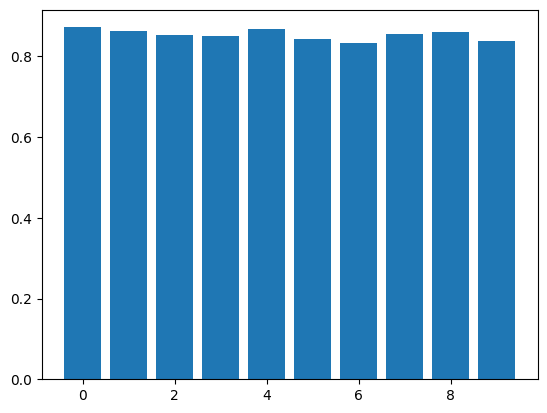

In [18]:
plt.bar(range(len(scores['test_accuracy'])),scores['test_accuracy'])


In [19]:
path ='D:\\Experiencia Cliente\\Modelo\\'

In [20]:
#Equilibrando las clases
# Extraer y_train transformado
X_train_smotetomek , y_train_transformed = pipe.named_steps['smote'].fit_resample(X_train, y_train)
#Estandarizando
X_train_smotetomek_scale = pipe.named_steps['standardscaler'].transform(X_train_smotetomek)
X_test_scale = pipe.named_steps['standardscaler'].transform(X_test)
# save the model


from pickle import dump
dump(pipe, open(path+'pipe.pkl', 'wb'))


In [21]:
X_train_smotetomek_scale= pd.DataFrame(X_train_smotetomek_scale, columns = X_train.columns)

X_test_scale = pd.DataFrame(X_test_scale, columns = X_test.columns)

In [22]:
import seaborn as sns

<Axes: >

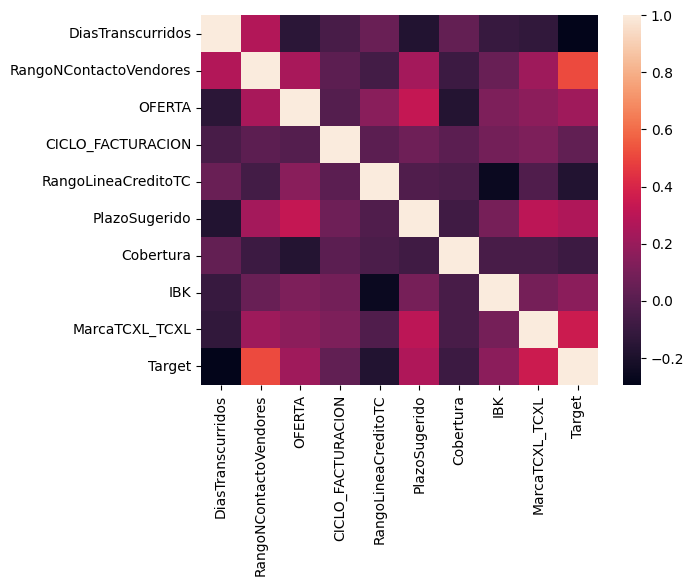

In [23]:
sns.heatmap(pd.concat([X_train_smotetomek_scale, y_train_transformed], axis=1).corr())

In [24]:
import pandas as pd

# Calcular la matriz de correlación
df = pd.concat([X_train_smotetomek_scale, y_train_transformed], axis=1)
correlation_matrix = df.corr()



# Identificar las variables correlacionadas
threshold = 0.6  # Umbral de correlación para considerar una alta correlación
correlated_variables = []
n = len(correlation_matrix.columns)
for i in range(n):
    for j in range(i+1, n):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            correlated_variables.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

# Crear un conjunto de variables a eliminar
variables_a_eliminar = set()

# Evaluar las correlaciones con el target y agregar las variables a eliminar
for var1, var2 in correlated_variables:
    corr_var1 = abs(df[var1].corr(df['Target']))
    corr_var2 = abs(df[var2].corr(df['Target']))
    if corr_var1 > corr_var2:
        variables_a_eliminar.add(var2)
        print(var1,'vs.',var2)
    else:
        variables_a_eliminar.add(var1)
        print(var2,'vs.',var1)

# Eliminar las variables del conjunto final de variables a eliminar
for var in variables_a_eliminar:
    df.drop(var, axis=1, inplace=True)

In [26]:
columns = [ x for x in X_train.columns if x not in variables_a_eliminar ]

X_train_smotetomek_scale_drop = X_train_smotetomek_scale[columns]
X_test_scale_drop = X_test_scale[columns]

In [27]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
# let's initialize a RF model 
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

# let's initialize Boruta
feat_selector = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
    max_iter=10  # number of iterations to perform
)

In [28]:
# N.B.: X and y must be numpy arrays
feat_selector.fit(X_train_smotetomek_scale_drop.values.astype(float), y_train_transformed.values.astype(float))

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	9
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	9 / 10
Confirmed: 	9
Tentative: 	0
Rejected: 	0


BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=84,
                                         random_state=RandomState(MT19937) at 0x29EE2F52040),
         max_iter=10, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x29EE2F52040, verbose=2)

In [29]:
# print support and ranking for each feature
print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", X_train_smotetomek_scale_drop.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])
    else:
        print("Doesn't pass the test: ",
              X_train_smotetomek_scale_drop.columns[i], " - Ranking: ", feat_selector.ranking_[i])


------Support and Ranking for each feature------
Passes the test:  DiasTranscurridos  - Ranking:  1
Passes the test:  RangoNContactoVendores  - Ranking:  1
Passes the test:  OFERTA  - Ranking:  1
Passes the test:  CICLO_FACTURACION  - Ranking:  1
Passes the test:  RangoLineaCreditoTC  - Ranking:  1
Passes the test:  PlazoSugerido  - Ranking:  1
Passes the test:  Cobertura  - Ranking:  1
Passes the test:  IBK  - Ranking:  1
Passes the test:  MarcaTCXL_TCXL  - Ranking:  1


In [35]:
accepted = X_train_smotetomek_scale_drop.columns[feat_selector.support_].to_list()
print('Accepted features:', accepted)


Accepted features: ['DiasTranscurridos', 'RangoNContactoVendores', 'OFERTA', 'CICLO_FACTURACION', 'RangoLineaCreditoTC', 'PlazoSugerido', 'Cobertura', 'IBK', 'MarcaTCXL_TCXL']


In [36]:

print(accepted)

['DiasTranscurridos', 'RangoNContactoVendores', 'OFERTA', 'CICLO_FACTURACION', 'RangoLineaCreditoTC', 'PlazoSugerido', 'Cobertura', 'IBK', 'MarcaTCXL_TCXL']


<Axes: >

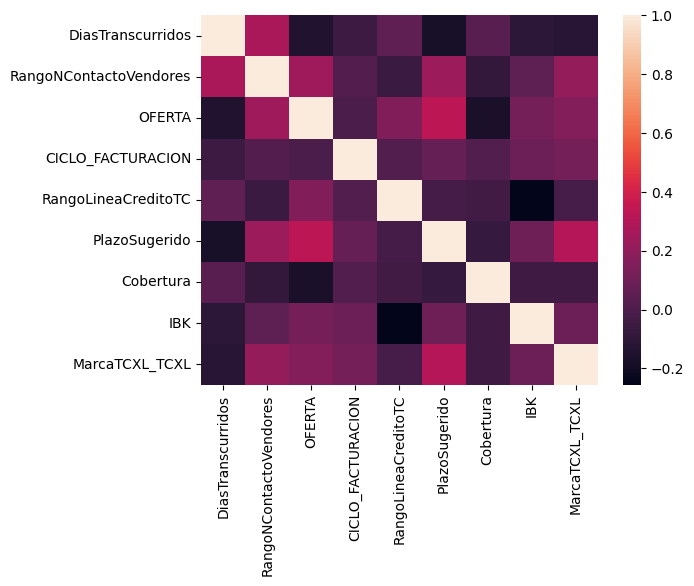

In [38]:
sns.heatmap(X_train_smotetomek_scale_drop[accepted].corr())

In [39]:
X_train_smotetomek_scale_drop_boruta = X_train_smotetomek_scale_drop[accepted]
X_test_scale_drop_boruta = X_test_scale_drop[accepted]

In [40]:
corr = X_train_smotetomek_scale_drop_boruta.corr()
corr[abs(corr)>=0.5].dropna(how='all')

,DiasTranscurridos,RangoNContactoVendores,OFERTA,CICLO_FACTURACION,RangoLineaCreditoTC,PlazoSugerido,Cobertura,IBK,MarcaTCXL_TCXL
DiasTranscurridos,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RangoNContactoVendores,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OFERTA,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
CICLO_FACTURACION,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
RangoLineaCreditoTC,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
PlazoSugerido,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Cobertura,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
IBK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
MarcaTCXL_TCXL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


<BarContainer object of 9 artists>

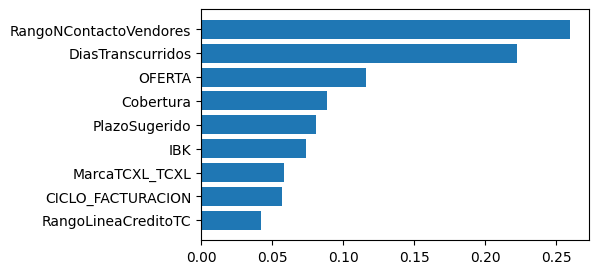

In [41]:
rf = RandomForestClassifier(random_state=123)
rf.fit(X_train_smotetomek_scale_drop_boruta, y_train_transformed)
importances = rf.feature_importances_
sorted_idx = rf.feature_importances_.argsort()
fig, axes =plt.subplots(figsize=(5,3))
axes.barh(X_train_smotetomek_scale_drop_boruta.columns[sorted_idx], rf.feature_importances_[sorted_idx])
#axes.sub_xlabel("Random Forest Feature Importance")

In [42]:
tf = pd.DataFrame(rf.feature_importances_[sorted_idx], X_train_smotetomek_scale_drop_boruta.columns[sorted_idx])
tf = tf.reset_index()
tf.rename(columns = {'index':'Variables' , 0: 'Valores'}, inplace=True)
tf.sort_values(by = 'Valores', ascending = False)

,Variables,Valores
8,RangoNContactoVendores,0.259909
7,DiasTranscurridos,0.222832
6,OFERTA,0.116196
5,Cobertura,0.088737
4,PlazoSugerido,0.080960
3,IBK,0.074122
2,MarcaTCXL_TCXL,0.058204
1,CICLO_FACTURACION,0.056767
0,RangoLineaCreditoTC,0.042272


In [43]:
# Selección de umbral (thresholder)
umbral = 0.03 # Establecer un umbral específico
variables_importantes = X_train_smotetomek_scale_drop_boruta.columns[importances >= umbral]
variables_importantes


Index(['DiasTranscurridos', 'RangoNContactoVendores', 'OFERTA',
       'CICLO_FACTURACION', 'RangoLineaCreditoTC', 'PlazoSugerido',
       'Cobertura', 'IBK', 'MarcaTCXL_TCXL'],
      dtype='object')

In [44]:
accepted = variables_importantes
#Ingresar variables
pd.DataFrame(variables_importantes, columns=['Variables']).to_csv(path+'variables.csv', index=False)

<BarContainer object of 9 artists>

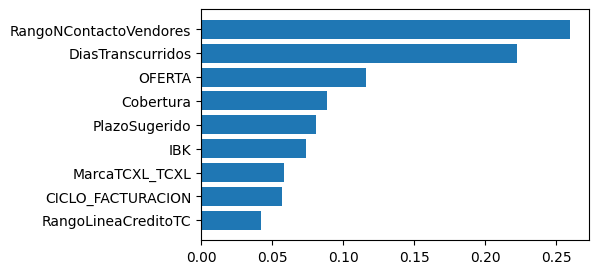

In [45]:
rf = RandomForestClassifier(random_state=123)
rf.fit(X_train_smotetomek_scale_drop_boruta[variables_importantes], y_train_transformed)
importances = rf.feature_importances_
sorted_idx = rf.feature_importances_.argsort()
fig, axes =plt.subplots(figsize=(5,3))
axes.barh(X_train_smotetomek_scale_drop_boruta[variables_importantes].columns[sorted_idx], rf.feature_importances_[sorted_idx])
#axes.sub_xlabel("Random Forest Feature Importance")

In [46]:
rf.feature_importances_[sorted_idx]

array([0.04227227, 0.05676727, 0.05820419, 0.07412168, 0.0809603 ,
       0.08873707, 0.1161963 , 0.22283195, 0.25990896])

In [47]:
tf = pd.DataFrame(rf.feature_importances_[sorted_idx], X_train_smotetomek_scale_drop_boruta[variables_importantes].columns[sorted_idx])
tf = tf.reset_index()
tf.rename(columns = {'index':'Variables' , 0: 'Valores'}, inplace=True)

In [48]:
tf.sort_values(by = 'Valores', ascending = True)

,Variables,Valores
0,RangoLineaCreditoTC,0.042272
1,CICLO_FACTURACION,0.056767
2,MarcaTCXL_TCXL,0.058204
3,IBK,0.074122
4,PlazoSugerido,0.080960
5,Cobertura,0.088737
6,OFERTA,0.116196
7,DiasTranscurridos,0.222832
8,RangoNContactoVendores,0.259909


In [49]:
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
rf =RandomForestClassifier()



In [50]:
cv_result =  cross_val_score(rf, X_train_smotetomek_scale_drop_boruta,y_train_transformed, cv=5, scoring='precision')

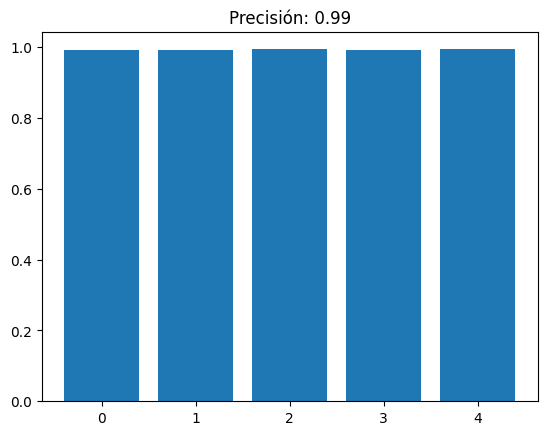

In [51]:
fig = plt.plot(fig_size = (10,5))

plt.bar(range(len(cv_result)),cv_result)
plt.title('Precisión: {:.2f}'.format(np.mean(cv_result)))
plt.xticks(range(len(cv_result)))
plt.show()


In [52]:
import lightgbm as lgb  

In [53]:
lg = lgb.LGBMClassifier()
lr = LogisticRegression()

In [54]:
parameters_lg = {
    'boosting_type': ['gbdt', 'goss'],
    'num_leaves': [2,3],
    'learning_rate': [0.1, 0.01,0.001],
    'n_estimators': [10, 20, 30],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1],
    'min_child_samples': [60,70]
}


In [55]:
parameters_rf = {
    'n_estimators': [10, 20, 50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3,4,5],
    'min_samples_split': [30, 40, 50],
    'min_samples_leaf': [30, 40, 50],
    'max_features': ['auto', 'sqrt','log2'],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced','auto']
}

In [56]:
parameters_lr = {
'penalty': ['l1', 'l2'],
'C': [0.1, 1.0, 10.0],
'fit_intercept': [True, False],
'class_weight': [None, 'balanced','auto'],
'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
'max_iter': [50,100, 150, 200, 300, 400, 500],
'intercept_scaling': [1, 2, 3,5],
'multi_class': ['auto', 'ovr', 'multinomial'],
'warm_start': [True, False]
}        

In [57]:
from sklearn.metrics import f1_score, make_scorer
X_train_smotetomek_scale_drop_boruta = X_train_smotetomek_scale_drop_boruta[variables_importantes]
X_test_scale_drop_boruta = X_test_scale_drop_boruta[variables_importantes]

In [58]:
#grid = GridSearchCV(lr, parameters_lr,cv=5, n_jobs=-1, scoring=make_scorer(f1_score, average='marco'))
grid = GridSearchCV(lr, parameters_lr,cv=5, n_jobs=-1, scoring='accuracy')

grid.fit(X_train_smotetomek_scale_drop_boruta, y_train_transformed) 

d:\Experiencia Cliente\Modelo\env\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
87360 fits failed out of a total of 151200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10080 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Experiencia Cliente\Modelo\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Experiencia Cliente\Modelo\env\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Experiencia Cliente\Modelo\env\Lib\site-packages\sklearn\linear_model\_

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1.0, 10.0],
                         'class_weight': [None, 'balanced', 'auto'],
                         'fit_intercept': [True, False],
                         'intercept_scaling': [1, 2, 3, 5],
                         'max_iter': [50, 100, 150, 200, 300, 400, 500],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'],
                         'warm_start': [True, False]},
             scoring='accuracy')

In [59]:
dump(grid, open(path+'model.pkl', 'wb'))

In [60]:
grid.best_params_

{'C': 0.1,
 'class_weight': None,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 300,
 'multi_class': 'multinomial',
 'penalty': 'l1',
 'solver': 'saga',
 'warm_start': True}

In [61]:
X_train_smotetomek_scale_drop_boruta.shape

(6946, 9)

In [62]:
data = grid.cv_results_['mean_test_score']


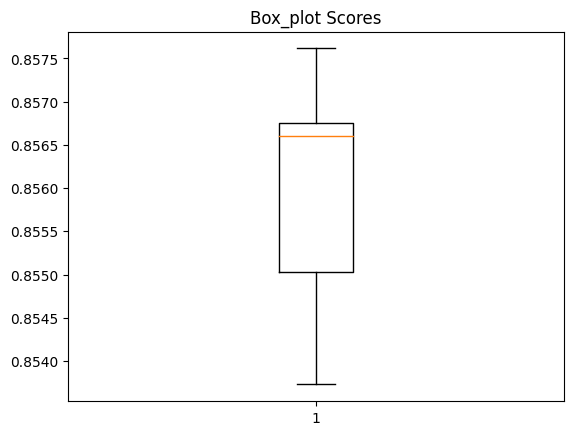

In [63]:
plt.boxplot(data[~np.isnan(data)])
plt.title('Box_plot Scores')
plt.show()

In [64]:
y_predict_train =grid.predict(X_train_smotetomek_scale_drop_boruta)
y_predict_test =grid.predict(X_test_scale_drop_boruta)


y_probas_train = grid.predict_proba(X_train_smotetomek_scale_drop_boruta)
y_probas_test  = grid.predict_proba(X_test_scale_drop_boruta)

In [65]:
from Modulos.ValidadorModelos import Graficos, Performance

,Metrica,Valor
0,ks,0.728189
1,gini,0.856246
2,roc,0.928123
3,accuracy,0.857328
4,precision,0.855384
5,recall,0.860063


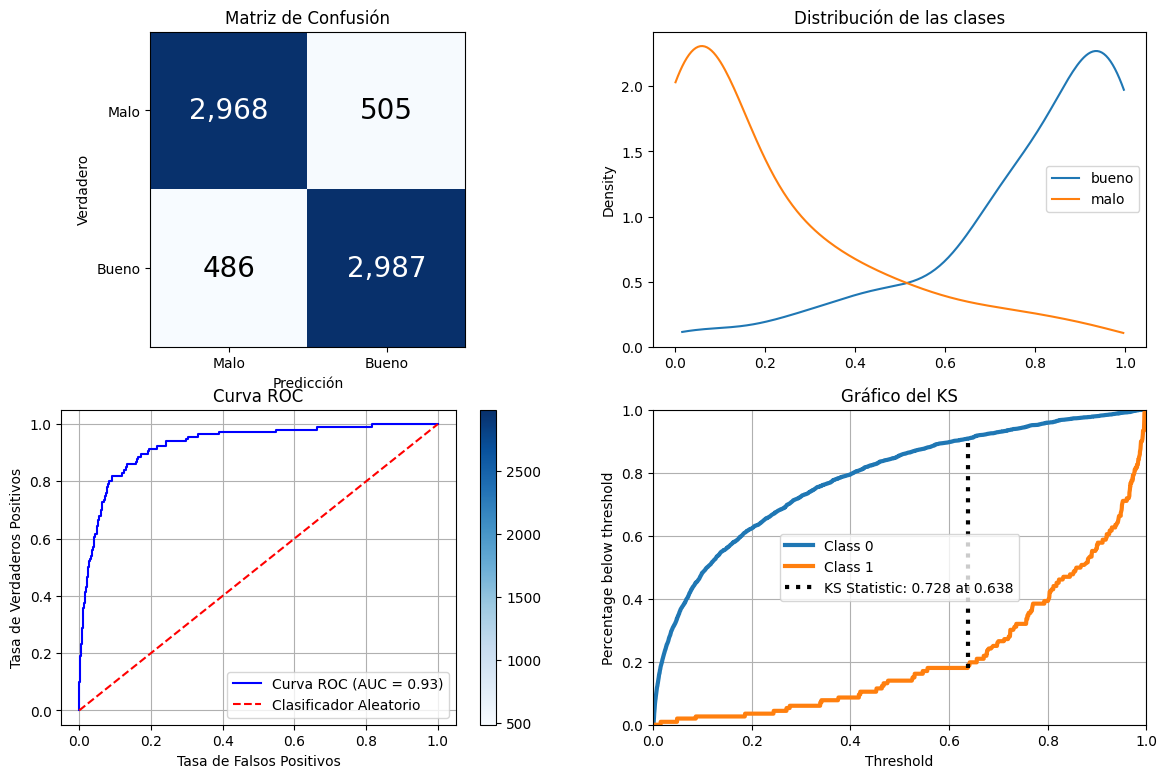

In [66]:
Graficos(y_train_transformed,y_probas_train)
Performance(y_train_transformed,y_probas_train)

,Metrica,Valor
0,ks,0.728256
1,gini,0.855078
2,roc,0.927539
3,accuracy,0.854632
4,precision,0.158333
5,recall,0.855856


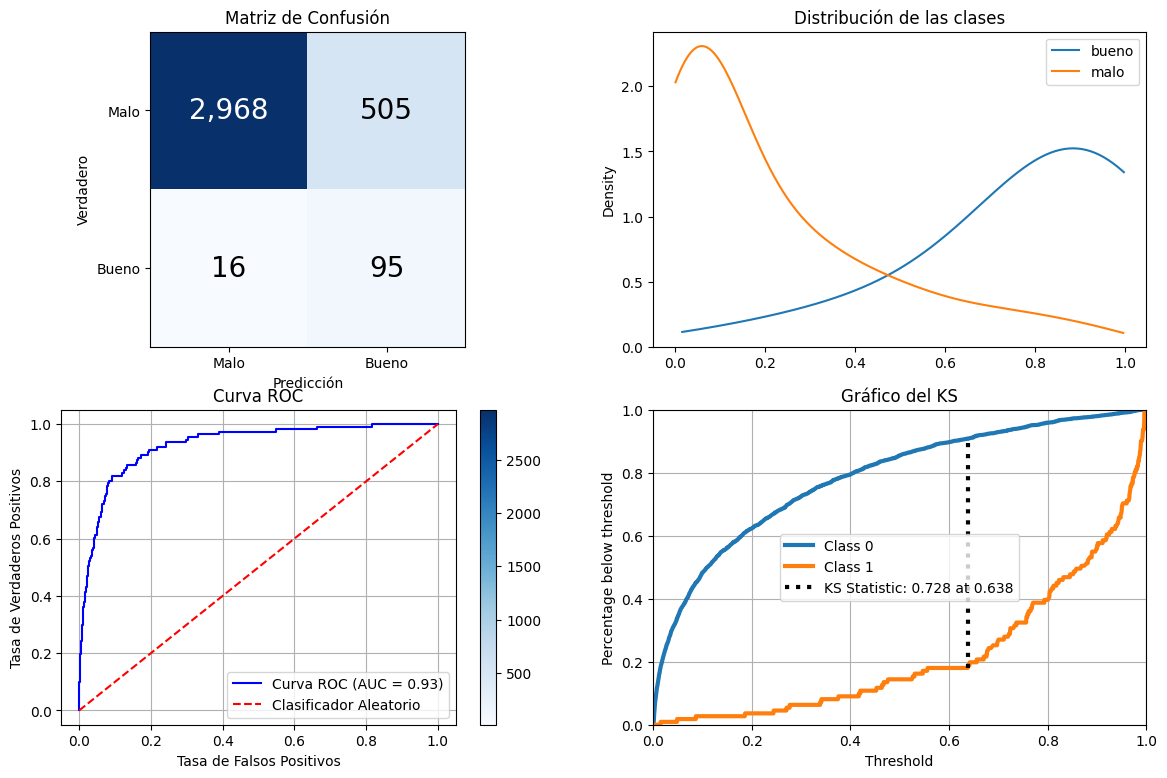

In [67]:
X_val_transformed = pipe.named_steps['standardscaler'].transform(X_train)
X_val_transformed = pd.DataFrame(X_val_transformed, columns = X_train.columns)
y_probas_val  = grid.predict_proba(X_val_transformed[accepted])
y_val = y_train
Graficos(y_val,y_probas_val)
Performance(y_val,y_probas_val)


,Metrica,Valor
0,ks,0.787071
1,gini,0.882952
2,roc,0.941476
3,accuracy,0.856187
4,precision,0.156463
5,recall,0.821429


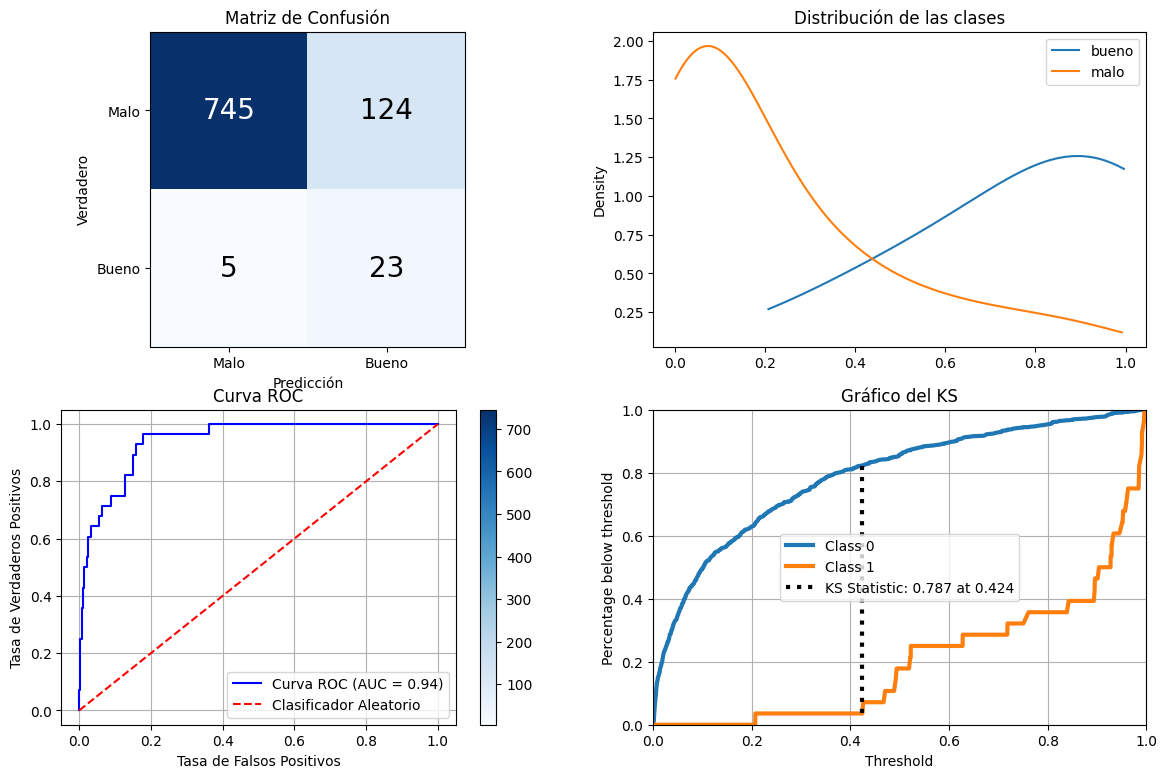

In [68]:
Graficos(y_test,y_probas_test)
Performance(y_test,y_probas_test)

['Base_gestion_CDXL_202304_TGS.xlsx', 'Base_gestion_CDXL_202304_TGS_Choc.xlsx']
[]
DEPARTAMENTO
LIMA           0.689410
CALLAO         0.051666
AREQUIPA       0.047328
LA LIBERTAD    0.040623
PIURA          0.024453
LAMBAYEQUE     0.020114
ICA            0.017354
ANCASH         0.015776
JUNIN          0.015579
CUSCO          0.013410
SAN MARTIN     0.012818
TACNA          0.009663
CAJAMARCA      0.009268
LORETO         0.006705
HUANUCO        0.005916
PUNO           0.005127
UCAYALI        0.004930
MOQUEGUA       0.004338
AYACUCHO       0.002366
TUMBES         0.002169
PASCO          0.000986
Name: proportion, dtype: float64


,Metrica,Valor
0,ks,0.660516
1,gini,0.771466
2,roc,0.885733
3,accuracy,0.828633
4,precision,0.126556
5,recall,0.818792


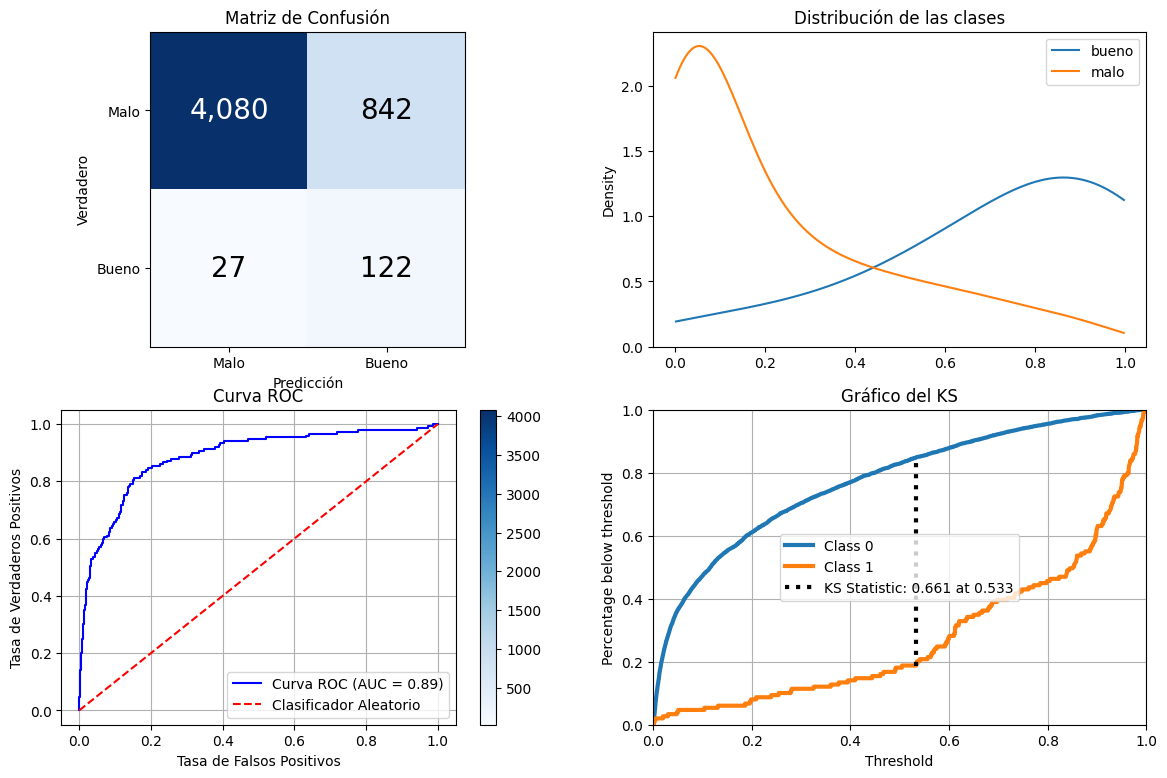

In [69]:
X_val, y_val = tratamiento('2023-04-30')
X_val_transformed = pipe.named_steps['standardscaler'].transform(X_val)
X_val_transformed = pd.DataFrame(X_val_transformed, columns = X_test.columns)
y_probas_val  = grid.predict_proba(X_val_transformed[accepted])
Graficos(y_val,y_probas_val)
Performance(y_val,y_probas_val)
#binnings(y_val,y_probas_val, bins=4)



['Base_gestion_CDXL_202305_TGS.xlsx', 'Base_gestion_CDXL_202305_TGS_Choc.xlsx']
[]
DEPARTAMENTO
LIMA           0.740693
CALLAO         0.045620
LA LIBERTAD    0.037956
AREQUIPA       0.036131
PIURA          0.020620
LAMBAYEQUE     0.018613
ICA            0.016058
ANCASH         0.014051
JUNIN          0.012591
CUSCO          0.011131
TACNA          0.008394
CAJAMARCA      0.006569
HUANUCO        0.006387
SAN MARTIN     0.006022
MOQUEGUA       0.005292
LORETO         0.004015
UCAYALI        0.003467
PUNO           0.003285
TUMBES         0.001642
AYACUCHO       0.001095
PASCO          0.000365
Name: proportion, dtype: float64


,Metrica,Valor
0,ks,0.643117
1,gini,0.807940
2,roc,0.903970
3,accuracy,0.813321
4,precision,0.096745
5,recall,0.816794


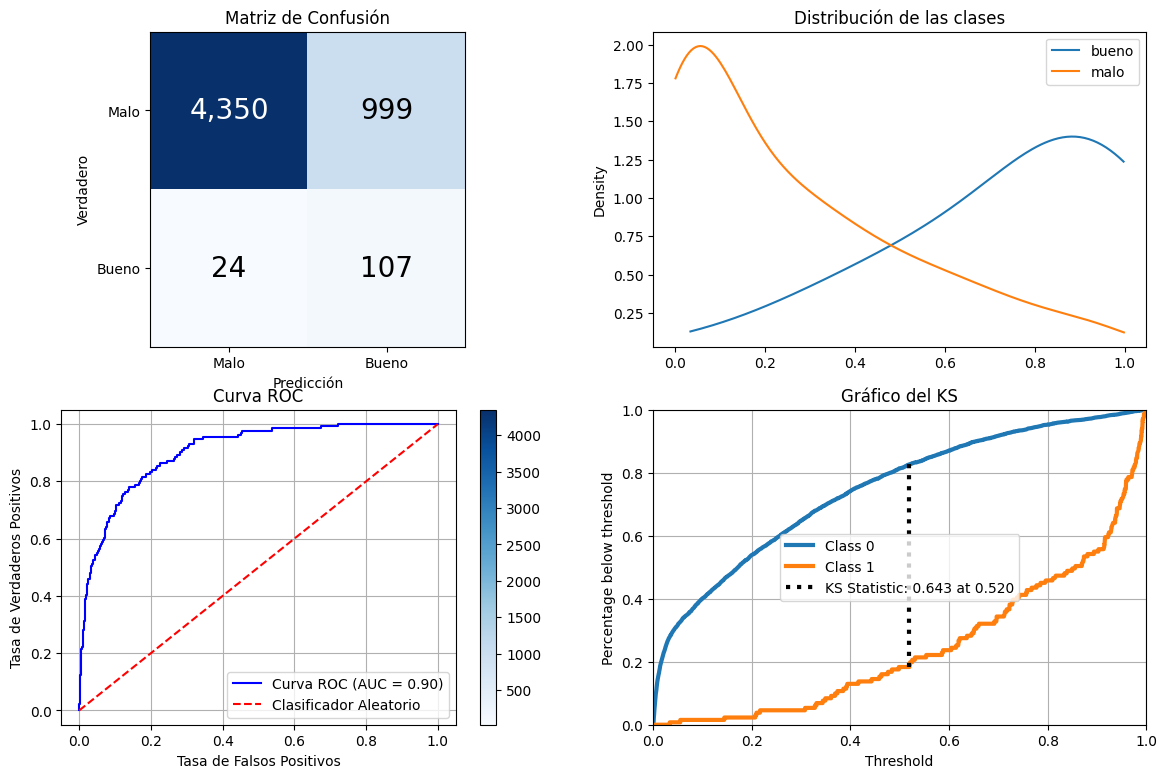

In [70]:
X_val, y_val = tratamiento('2023-05-31')
X_val_transformed = pipe.named_steps['standardscaler'].transform(X_val)
X_val_transformed = pd.DataFrame(X_val_transformed, columns = X_test.columns)
y_probas_val  = grid.predict_proba(X_val_transformed[accepted])
Graficos(y_val,y_probas_val)
Performance(y_val,y_probas_val)
#binnings(y_val,y_probas_val, bins=4)

['Base_gestion_CDXL_202306_TGS.xlsx', 'Base_gestion_CDXL_202306_TGS_Choc.xlsx']
[]
DEPARTAMENTO
LIMA           0.750133
CALLAO         0.046331
LA LIBERTAD    0.041733
AREQUIPA       0.031477
PIURA          0.019629
LAMBAYEQUE     0.018037
ICA            0.014324
CUSCO          0.011848
JUNIN          0.011671
ANCASH         0.011141
TACNA          0.008134
CAJAMARCA      0.006720
SAN MARTIN     0.006012
HUANUCO        0.004775
PUNO           0.004067
UCAYALI        0.003714
LORETO         0.003537
MOQUEGUA       0.002829
TUMBES         0.002122
AYACUCHO       0.001061
PASCO          0.000707
Name: proportion, dtype: float64


,Metrica,Valor
0,ks,0.692483
1,gini,0.842304
2,roc,0.921152
3,accuracy,0.803537
4,precision,0.121261
5,recall,0.862069


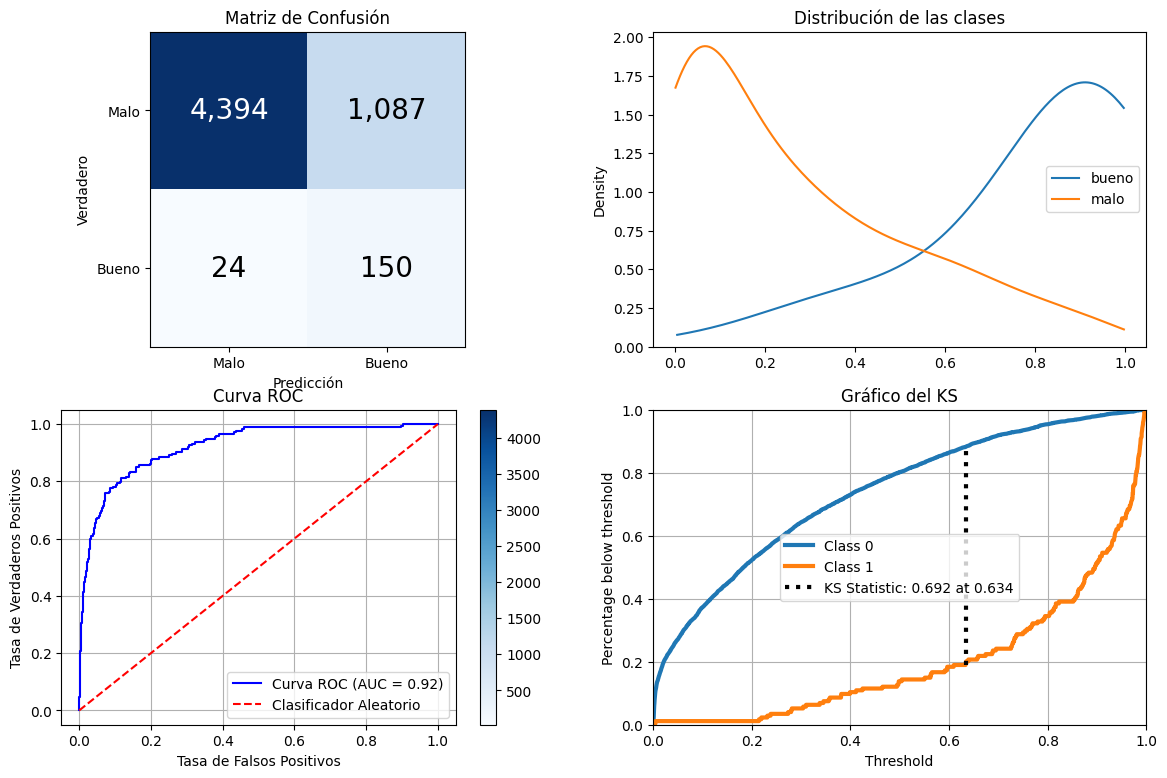

In [71]:
X_val, y_val = tratamiento('2023-06-30')
X_val_transformed = pipe.named_steps['standardscaler'].transform(X_val)
X_val_transformed = pd.DataFrame(X_val_transformed, columns = X_test.columns)
y_probas_val  = grid.predict_proba(X_val_transformed[accepted])
Graficos(y_val,y_probas_val)
Performance(y_val,y_probas_val)
#binnings(y_val,y_probas_val, bins=4)

['Base_gestion_CDXL_202307_TGS.xlsx', 'Base_gestion_CDXL_202307_TGS_Choc.xlsx']
[]
DEPARTAMENTO
LIMA           0.727293
CALLAO         0.050658
LA LIBERTAD    0.047534
AREQUIPA       0.043963
LAMBAYEQUE     0.016737
PIURA          0.014729
ICA            0.013390
CUSCO          0.013390
ANCASH         0.012720
JUNIN          0.010935
TACNA          0.008034
SAN MARTIN     0.007141
CAJAMARCA      0.006695
HUANUCO        0.005579
UCAYALI        0.004686
MOQUEGUA       0.004463
PUNO           0.004017
LORETO         0.004017
TUMBES         0.003347
PASCO          0.000446
AYACUCHO       0.000223
Name: proportion, dtype: float64


,Metrica,Valor
0,ks,0.730398
1,gini,0.860483
2,roc,0.930241
3,accuracy,0.854943
4,precision,0.157965
5,recall,0.848921


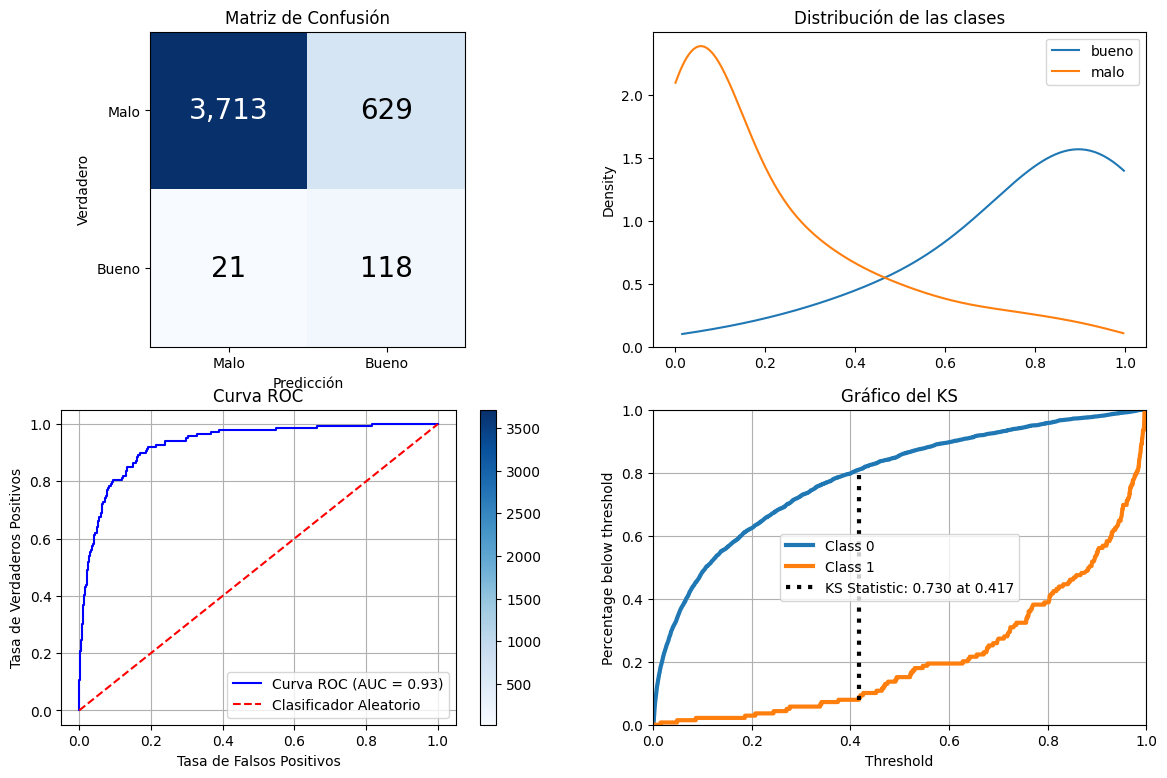

In [72]:
X_val, y_val = tratamiento('2023-07-31')
X_val_transformed = pipe.named_steps['standardscaler'].transform(X_val)
X_val_transformed = pd.DataFrame(X_val_transformed, columns = X_test.columns)
y_probas_val  = grid.predict_proba(X_val_transformed[accepted])
Graficos(y_val,y_probas_val)
Performance(y_val,y_probas_val)
#binnings(y_val,y_probas_val, bins=4)

['Base_gestion_CDXL_202308_TGS.xlsx', 'Base_gestion_CDXL_202308_TGS_BoosterPremium.xlsx', 'Base_gestion_CDXL_202308_TGS_Choc.xlsx', 'Base_gestion_CDXL_202308_TGS_Nuevos.xlsx']
['Flag_ORDENATE_CD']
DEPARTAMENTO
LIMA           0.724402
CALLAO         0.049919
LA LIBERTAD    0.048293
AREQUIPA       0.046204
LAMBAYEQUE     0.023915
ICA            0.017181
CUSCO          0.014627
JUNIN          0.012770
CAJAMARCA      0.011145
ANCASH         0.011145
PIURA          0.009752
TACNA          0.008126
SAN MARTIN     0.006269
PUNO           0.005805
MOQUEGUA       0.003947
HUANUCO        0.003018
LORETO         0.002090
PASCO          0.000697
UCAYALI        0.000697
Name: proportion, dtype: float64


real,0,1
binnis,,
G1,0.233126,0.798450
G2,0.252513,0.170543
G3,0.256821,0.023256
G4,0.257539,0.007752


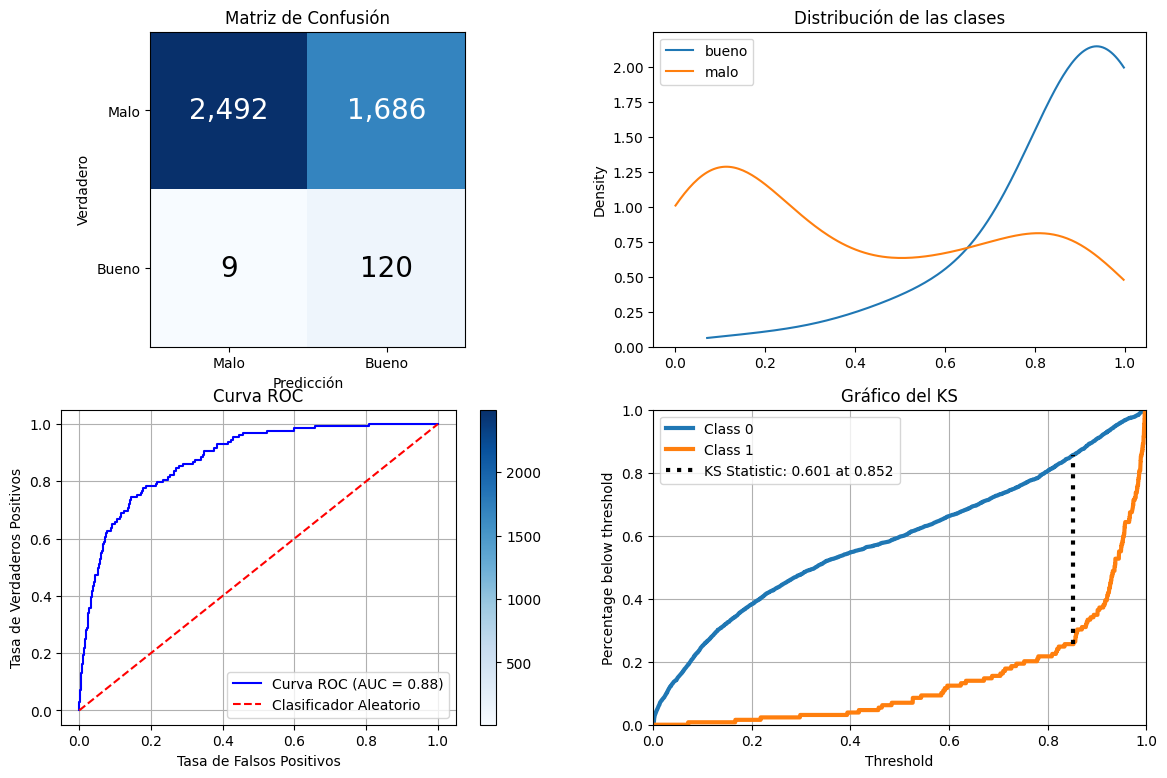

In [73]:
X_val, y_val = tratamiento('2023-08-31')
X_val_transformed = pipe.named_steps['standardscaler'].transform(X_val)
X_val_transformed = pd.DataFrame(X_val_transformed, columns = X_test.columns)
y_probas_val  = grid.predict_proba(X_val_transformed[accepted])
Graficos(y_val,y_probas_val)
Performance(y_val,y_probas_val)
binnings(y_val,y_probas_val, bins=4)

In [74]:
binnings(y_val,y_probas_val, bins=4)

real,0,1
binnis,,
G1,0.233126,0.798450
G2,0.252513,0.170543
G3,0.256821,0.023256
G4,0.257539,0.007752
